In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scanpy.external as sce

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, color_map = 'viridis_r')

/home/teach2_pkuhpc/gpfs1/xuzk/Anaconda/envs/py_3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.8.2 anndata==0.7.8 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [3]:
raw_file = 'write_LCA/h_LCA1-5_raw.h5ad'
qc_file = 'write_LCA/h_LCA1-5_qc.h5ad'
filtered_file = 'write_LCA/h_LCA1-5_filtered.h5ad'
pp_file = 'write_LCA/h_LCA1-5_pp.h5ad'
results_file = 'write_LCA/h_LCA1-5.h5ad'  # the file that will store the analysis results

In [4]:
adata=sc.read_h5ad(filtered_file)
adata

AnnData object with n_obs × n_vars = 32686 × 41861
    obs: 'Barcode', 'Patient', 'Library', 'Most_likely_LM22_cell_type', 'Major_cell_type', 'Minor_subset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'label_singleR'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Normalization
Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [6]:
sc.pp.log1p(adata)

In [7]:
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=8, min_disp=0.5) 

extracting highly variable genes
    finished (0:00:12)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [8]:
adata.var['highly_variable'].value_counts(normalize=False)

False    37494
True      4367
Name: highly_variable, dtype: int64

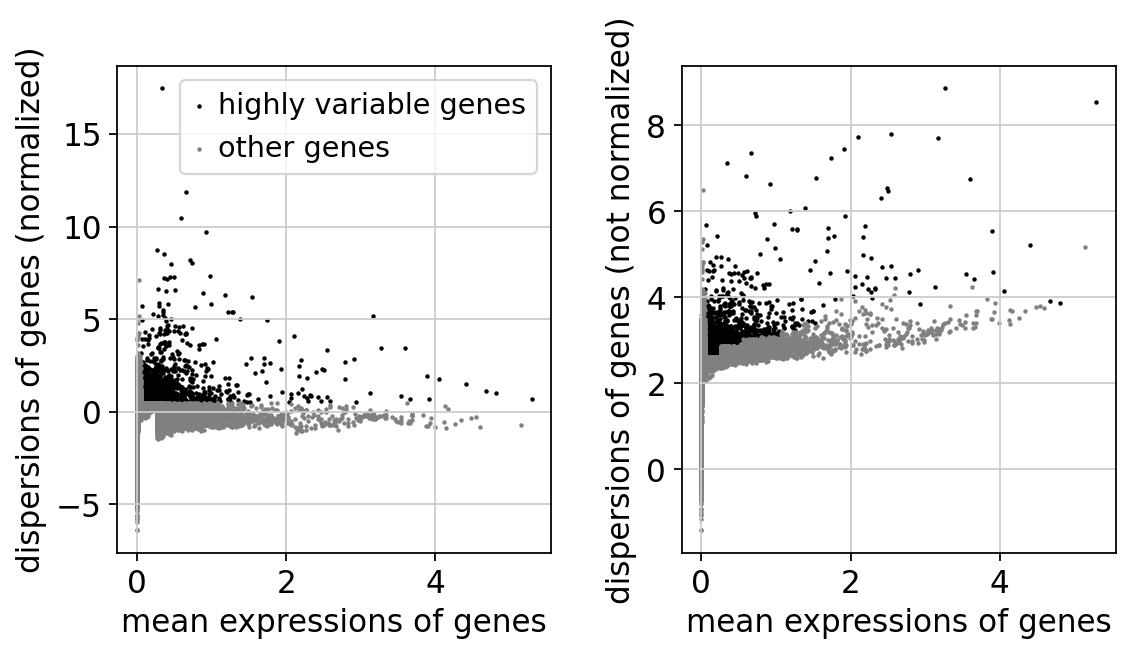

In [9]:
sc.pl.highly_variable_genes(adata)

In [10]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [11]:
sc.pp.regress_out(adata, ['total_counts','pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:01:44)


In [12]:
sc.pp.scale(adata, max_value=10)

# PCA

In [13]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)


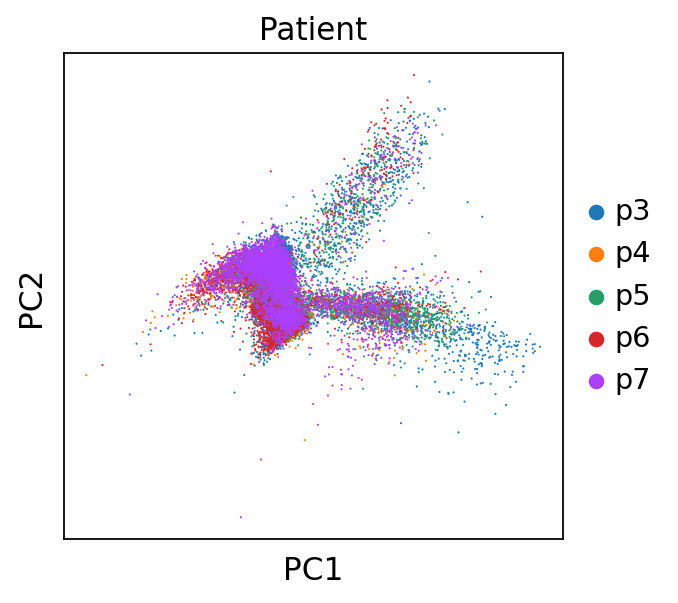

In [14]:
sc.pl.pca(adata, color='Patient')

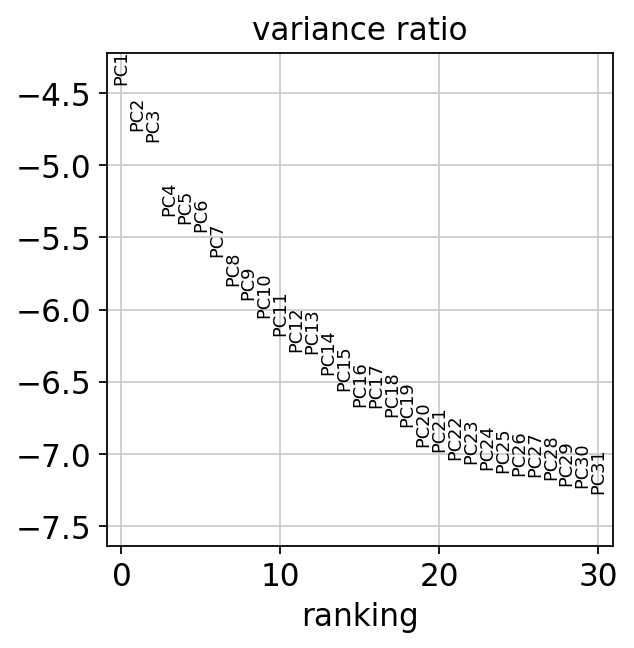

In [15]:
sc.pl.pca_variance_ratio(adata, log=True)

# Computing the neighborhood graph

In [16]:
sc.pp.neighbors(adata, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


# Embedding the neighborhood graph

In [17]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:38)


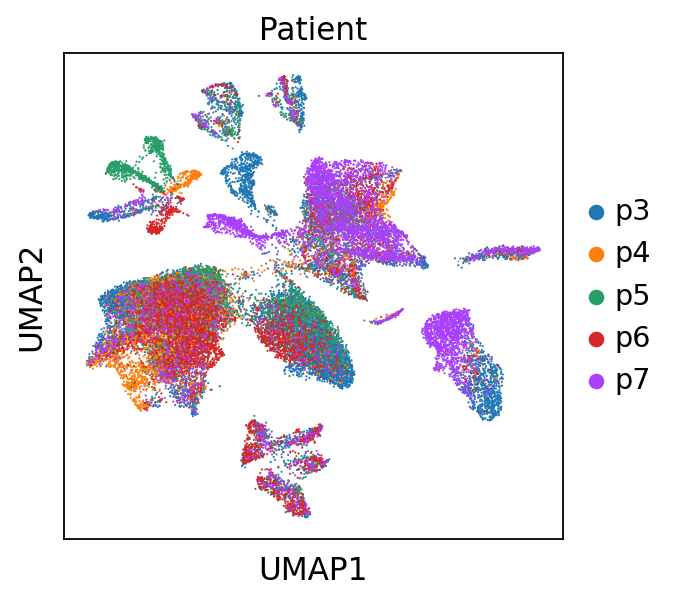

In [18]:
sc.pl.umap(adata, color='Patient')

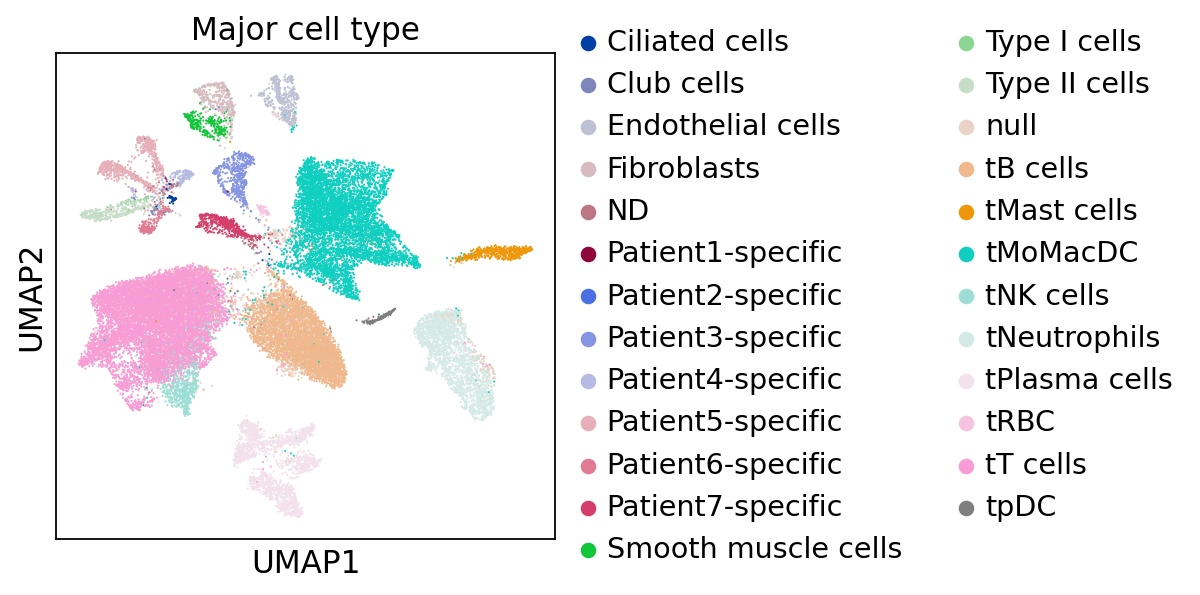

In [23]:
sc.pl.umap(adata, color='Major cell type')

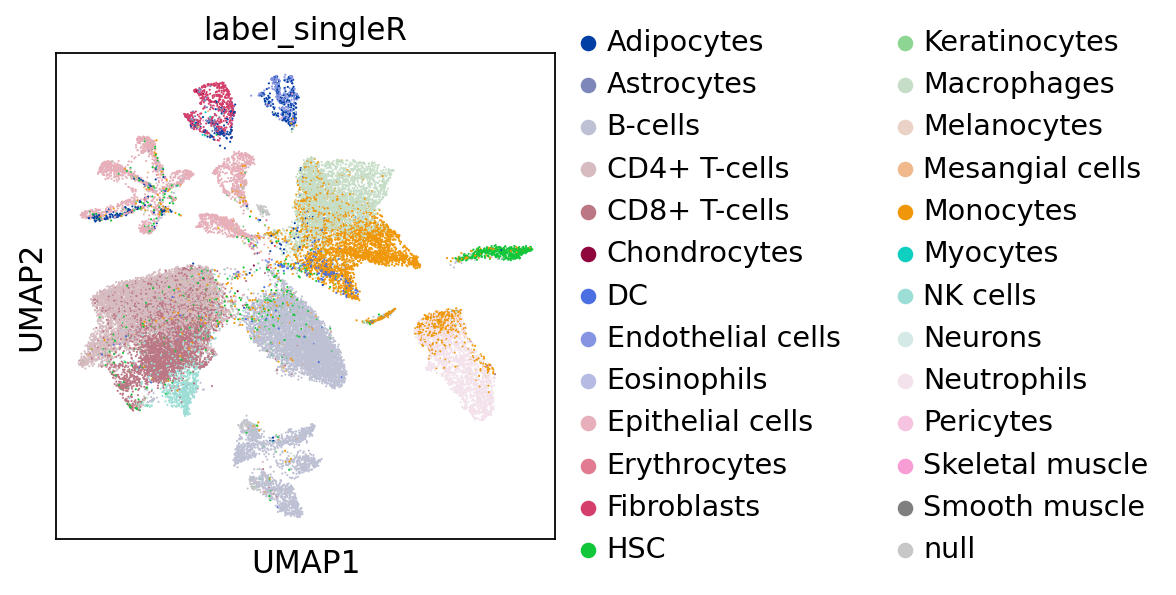

In [24]:
sc.pl.umap(adata, color='label_singleR')

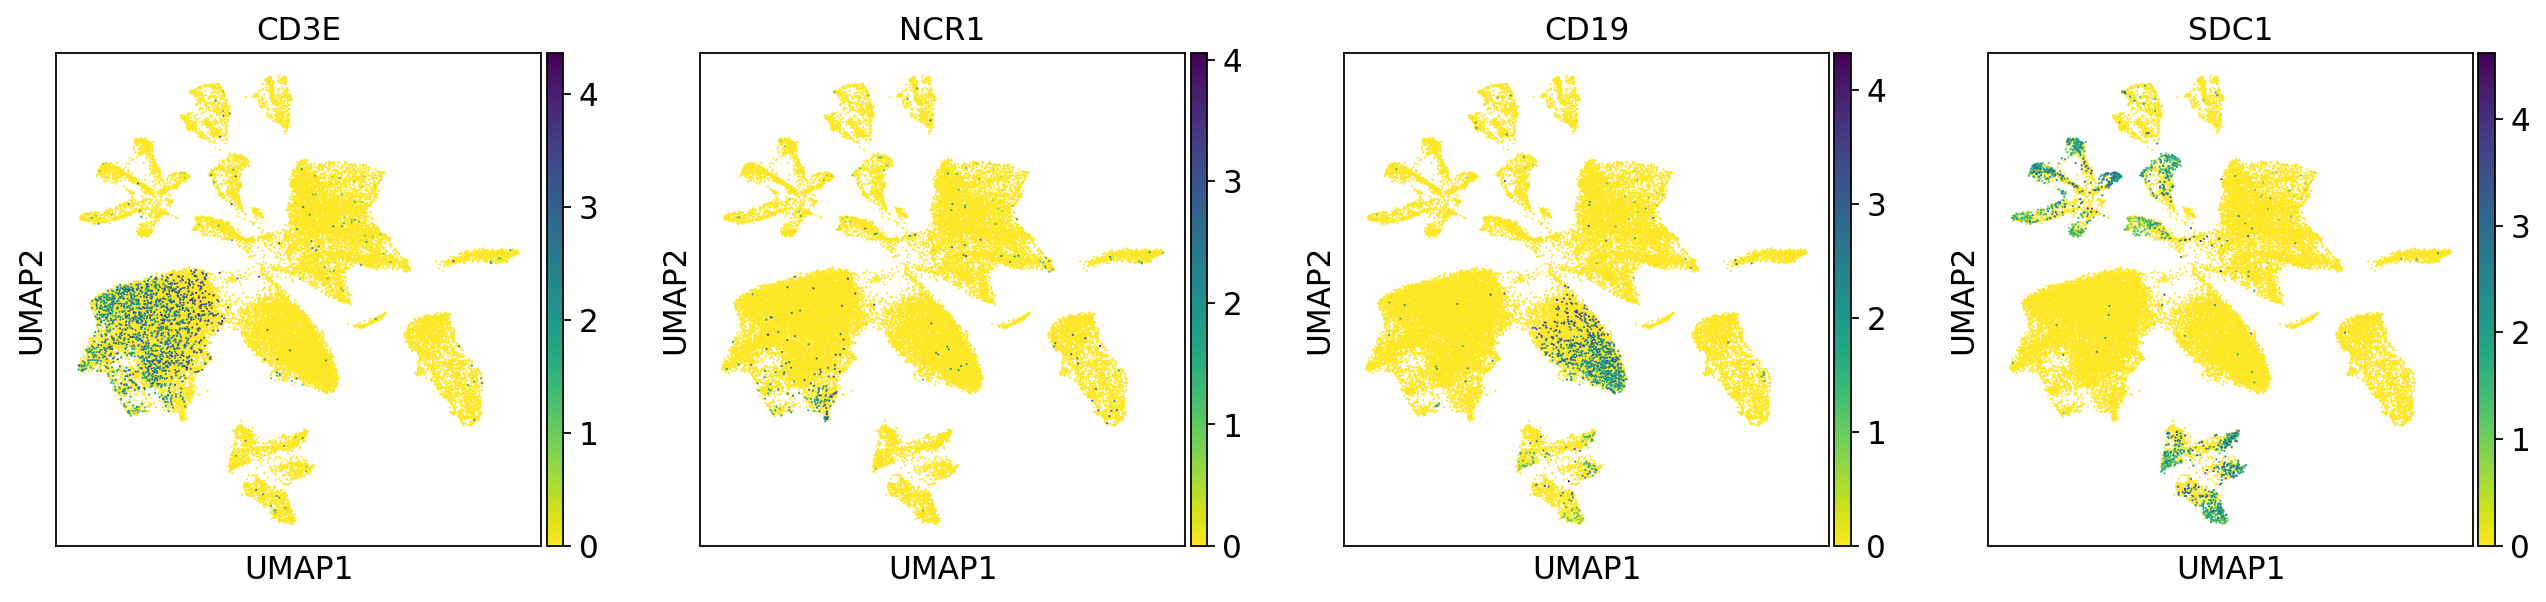

In [37]:
sc.pl.umap(adata, color=['CD3E','NCR1','CD19','SDC1'])

# Clustering the neighborhood graph 

In [19]:
sc.tl.leiden(adata, resolution = 0.1)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


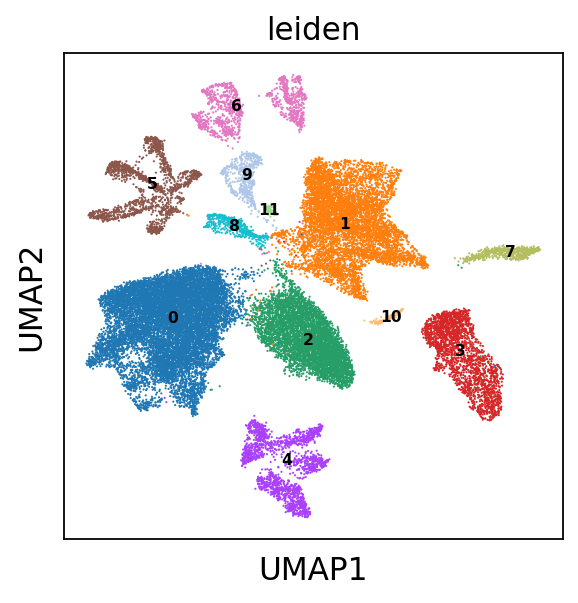

In [20]:
sc.pl.umap(adata, color=['leiden'], legend_loc='on data', legend_fontsize=7)

In [21]:
adata.write(results_file)